# Install Dependencies

In [1]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib

# Import Dependencies

In [2]:
# Import standard dependencies
from IPython.display import display, Image

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)



In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# Collect Positives and Anchors
## Untar Labelled Faces in the Wild Dataset

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
# Import uuid library to generate unique image names
import uuid



In [10]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\210cf57b-ac0d-11ec-93b9-48e7dac2a528.jpg'

In [11]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# Load and Preprocess Images

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(150)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(150)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(150)

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'data\\anchor\\ac64739a-a855-11ec-8483-48e7dac2a528.jpg'


## Preprocessing - Scale and Resize

In [15]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [16]:
img = preprocess('data\\anchor\\71b4fde4-a854-11ec-993c-48e7dac2a528.jpg')

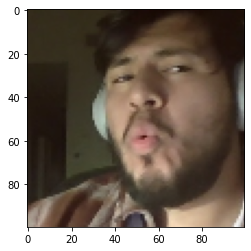

In [17]:
plt.imshow(img)

In [18]:


img.numpy().max() 



0.9892157

In [19]:


img.numpy().min() 



0.012745098

## Create Labelled Dataset

In [20]:

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [21]:


samples = data.as_numpy_iterator()



In [22]:


exampple = samples.next()



In [23]:


exampple



(b'data\\anchor\\ac29bacc-a855-11ec-8c52-48e7dac2a528.jpg',
 b'data\\positive\\c8d8d23c-a855-11ec-97df-48e7dac2a528.jpg',
 1.0)

In [24]:


def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)



In [25]:


res = preprocess_twin(*exampple)



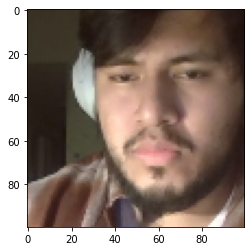

In [29]:
plt.imshow(res[1])

In [30]:
res[2]

1.0

In [31]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000) #or 1024 like in vid



In [32]:
samples = data.as_numpy_iterator()

In [33]:
len(samples.next())

3

In [34]:
samp = samples.next()

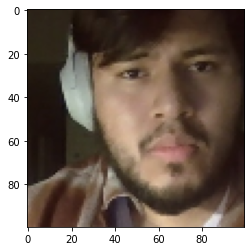

In [35]:
plt.imshow(samp[0])

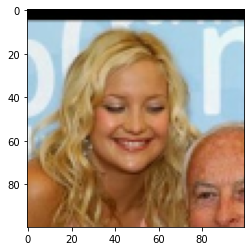

In [38]:
plt.imshow(samp[1])

In [40]:
samp[2]  # 1.0 = True ; 0.0 = False

0.0

In [41]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)



In [42]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)



# Model Engineering

## Build Embedding Layer

In [43]:
inp = Input(shape=(100,100,3), name='input_image') #DIFF VALUES IN VID

In [44]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [45]:

c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [46]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [47]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [48]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [49]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [50]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [51]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [52]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [54]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [55]:


embedding = make_embedding()



In [56]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [57]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [58]:
l1 = L1Dist()

In [59]:
l1

#  Make Siamese Model

In [60]:


input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))



In [61]:


inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)



In [62]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [63]:


siamese_layer = L1Dist()

In [64]:
distances = siamese_layer(inp_embedding, val_embedding)

In [65]:
classifier = Dense(1, activation='sigmoid')(distances)

In [66]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [67]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [68]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [69]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [70]:
siamese_model = make_siamese_model()

In [71]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [72]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [73]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [74]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [75]:
test_batch = train_data.as_numpy_iterator()

In [76]:
batch_1 = test_batch.next()

In [77]:
X = batch_1[:2]

In [78]:
y = batch_1[2]

In [79]:

y

array([0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [80]:
tf.losses.BinaryCrossentropy??

In [81]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

# Build Training Loop

In [82]:

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall



In [83]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# Training the model

In [84]:
EPOCHS = 50

In [85]:


train(train_data, EPOCHS)




 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
14/14 [==============================] - 159s 11s/step
0.8203474 0.14705883 1.0

 Epoch 2/50
14/14 [==============================] - 159s 11s/step
0.11680509 0.6862745 0.9859155

 Epoch 3/50
14/14 [==============================] - 155s 11s/step
0.0021947348 0.9266055 0.97115386

 Epoch 4/50
14/14 [==============================] - 154s 11s/step
0.03716969 0.980198 0.99

 Epoch 5/50
14/14 [==============================] - 155s 11s/step
0.01704709 0.97979796 1.0

 Epoch 6/50
14/14 [==============================] - 154s 11s/step
0.002077778 1.0 1.0

 Epoch 7/50
14/14 [==============================] - 156s 11s/step
0.0031918318 1.0 1.0

 Epoch 8/50
14/14 [==============================] - 157s 11s/step
0.005951839 1.0 0.9904762

 Epoch 9/50
14/14 [==============================] - 157s 11s/step
0.00032250478 1.0 1.0

 Ep

#  Evaluate Model
##  Import Metrics

In [86]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [87]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [88]:


y_hat = siamese_model.predict([test_input, test_val])

In [89]:


# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]

In [90]:
y_true

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [91]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [92]:


# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()



1.0

In [93]:


r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())



1.0 1.0


#  Viz Results

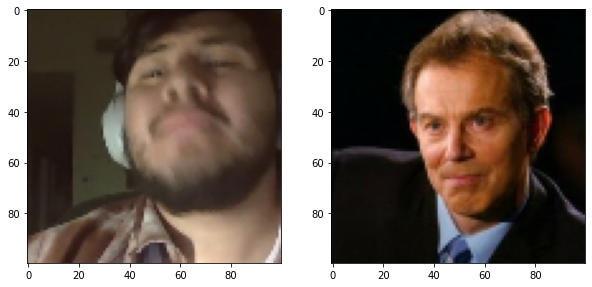

In [100]:


# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()



In [101]:


# Save weights
siamese_model.save('siamesemodelv2.h5')



In [102]:

L1Dist

__main__.L1Dist

In [103]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [104]:


# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])



array([[9.9989909e-01],
       [9.9999106e-01],
       [1.0809153e-08],
       [1.3862744e-08],
       [7.4566870e-08],
       [9.9987149e-01],
       [8.0611051e-07],
       [9.9994487e-01],
       [9.9999940e-01],
       [9.9999893e-01]], dtype=float32)

In [105]:

# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real Time Test
## Verification Function

In [107]:
os.listdir(os.path.join('application_data', 'verification_images'))

['960cefd0-a854-11ec-acfe-48e7dac2a528.jpg',
 '9621fbbf-a854-11ec-86d9-48e7dac2a528.jpg',
 '96684fab-a854-11ec-a3df-48e7dac2a528.jpg',
 '96a9f4e2-a854-11ec-acf1-48e7dac2a528.jpg',
 '96cd17e2-a854-11ec-8ce3-48e7dac2a528.jpg',
 '97823f31-a854-11ec-812d-48e7dac2a528.jpg',
 '97d8238e-a854-11ec-b806-48e7dac2a528.jpg',
 '989c2518-a854-11ec-b7bb-48e7dac2a528.jpg',
 'c8d8d23c-a855-11ec-97df-48e7dac2a528.jpg',
 'c8f2eeae-a855-11ec-b4d4-48e7dac2a528.jpg',
 'c9433178-a855-11ec-b6a3-48e7dac2a528.jpg',
 'c9f6bdd6-a855-11ec-889f-48e7dac2a528.jpg',
 'c9fdabaa-a855-11ec-805d-48e7dac2a528.jpg',
 'ca6045c3-a855-11ec-99f2-48e7dac2a528.jpg',
 'ca674a69-a855-11ec-8d7f-48e7dac2a528.jpg',
 'ca93ff4d-a855-11ec-a834-48e7dac2a528.jpg',
 'caadd37f-a855-11ec-b897-48e7dac2a528.jpg',
 'cad5dce9-a855-11ec-8d23-48e7dac2a528.jpg',
 'cb178347-a855-11ec-a1e8-48e7dac2a528.jpg',
 'cb59227c-a855-11ec-8af2-48e7dac2a528.jpg',
 'cb817de4-a855-11ec-8aa0-48e7dac2a528.jpg',
 'cb9fe2dd-a855-11ec-9007-48e7dac2a528.jpg',
 'cbf3d26b

In [108]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [109]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\960cefd0-a854-11ec-acfe-48e7dac2a528.jpg
application_data\verification_images\9621fbbf-a854-11ec-86d9-48e7dac2a528.jpg
application_data\verification_images\96684fab-a854-11ec-a3df-48e7dac2a528.jpg
application_data\verification_images\96a9f4e2-a854-11ec-acf1-48e7dac2a528.jpg
application_data\verification_images\96cd17e2-a854-11ec-8ce3-48e7dac2a528.jpg
application_data\verification_images\97823f31-a854-11ec-812d-48e7dac2a528.jpg
application_data\verification_images\97d8238e-a854-11ec-b806-48e7dac2a528.jpg
application_data\verification_images\989c2518-a854-11ec-b7bb-48e7dac2a528.jpg
application_data\verification_images\c8d8d23c-a855-11ec-97df-48e7dac2a528.jpg
application_data\verification_images\c8f2eeae-a855-11ec-b4d4-48e7dac2a528.jpg
application_data\verification_images\c9433178-a855-11ec-b6a3-48e7dac2a528.jpg
application_data\verification_images\c9f6bdd6-a855-11ec-889f-48e7dac2a528.jpg
application_data\verification_images\c9fdabaa-a855-11ec-805d-48e

In [110]:


def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified



# OpenCV Real Time Verification

In [111]:

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()



True
True
False


In [112]:


np.sum(np.squeeze(results) > 0.9)

0

In [113]:
results

[array([[0.00133255]], dtype=float32),
 array([[0.00031295]], dtype=float32),
 array([[0.0039517]], dtype=float32),
 array([[0.00082001]], dtype=float32),
 array([[0.00127685]], dtype=float32),
 array([[0.00156924]], dtype=float32),
 array([[0.00112671]], dtype=float32),
 array([[1.6495285e-05]], dtype=float32),
 array([[0.00011153]], dtype=float32),
 array([[0.00020367]], dtype=float32),
 array([[9.166705e-06]], dtype=float32),
 array([[5.7672187e-05]], dtype=float32),
 array([[5.7672187e-05]], dtype=float32),
 array([[4.5549157e-05]], dtype=float32),
 array([[4.5549157e-05]], dtype=float32),
 array([[0.01041877]], dtype=float32),
 array([[0.00246742]], dtype=float32),
 array([[0.00136125]], dtype=float32),
 array([[8.8630404e-05]], dtype=float32),
 array([[3.546927e-06]], dtype=float32),
 array([[1.2293264e-08]], dtype=float32),
 array([[1.5904206e-08]], dtype=float32),
 array([[2.0144867e-05]], dtype=float32),
 array([[2.337084e-05]], dtype=float32),
 array([[0.00015205]], dtype=flo